# Finantier Assessment

## Data Preprocessing

In [75]:
import pandas as pd

In [76]:
# configs
fp_data = '../project/data/finantier_data_technical_test_dataset.csv'
fp_encoder = '../project/preprocessing/encoder.pickle'

In [77]:
import pickle
from sklearn.preprocessing import OneHotEncoder

In [78]:
def load_data(fp):
    df = pd.read_csv(fp)

    # drop error rows
    df = df[~df['ErrorIndicator'].notna()]
    df = df.drop('ErrorIndicator', axis=1)
    df = df[~df.isnull().all(axis=1)]                       # null rows due to formatting

    return df

    
def process_telecom_data(df, fp, train_encoding=False, target=False):
    # TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df.TotalCharges.replace(" ", "0"))

    # encode target
    if target:
        mappings = {'No':0, 'Yes':1}
        df['Default'] = df.Default.map(mappings).fillna(0)
    # encode features
    # enumerate categorical columns
    cat_cols = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"]

    df_cat = df[cat_cols]

    if train_encoding:     
        # Instantiating the Scikit-Learn OHE object
        ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
        
        # Fitting the DataFrame to the Scikit-Learn one-hot encoder
        dummies = ohe.fit_transform(df_cat)

        # save trained encoder for future use
        with open(fp, 'wb') as f:
            pickle.dump(ohe, f)

    else:
        # load pickled encoder
        with open(fp, 'rb') as f:
            ohe = pickle.load(f)
            
        dummies = ohe.transform(df_cat)
        
    # Using the output dummies and transformer categories to produce a cleaner looking dataframe
    dummies_df = pd.DataFrame(dummies)
    dummies_df.columns = ohe.get_feature_names_out()

    numeric_df = df.drop(cat_cols, axis=1).reset_index(drop=True)

    df = pd.concat([dummies_df, numeric_df], axis=1)

    return df

In [79]:
df = load_data(fp_data)

In [80]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Default'],
      dtype='object')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7040 entries, 1 to 7047
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7040 non-null   object 
 1   gender            7040 non-null   object 
 2   SeniorCitizen     7040 non-null   float64
 3   Partner           7040 non-null   object 
 4   Dependents        7040 non-null   object 
 5   tenure            7040 non-null   float64
 6   PhoneService      7040 non-null   object 
 7   MultipleLines     7040 non-null   object 
 8   InternetService   7040 non-null   object 
 9   OnlineSecurity    7040 non-null   object 
 10  OnlineBackup      7040 non-null   object 
 11  DeviceProtection  7040 non-null   object 
 12  TechSupport       7040 non-null   object 
 13  StreamingTV       7040 non-null   object 
 14  StreamingMovies   7040 non-null   object 
 15  Contract          7040 non-null   object 
 16  PaperlessBilling  7040 non-null   object 


In [70]:
df_final = process_telecom_data(df, fp_encoder, train_encoding=True, target=True)

In [71]:
df_final.head()

,gender_Male,SeniorCitizen_1.0,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID,tenure,MonthlyCharges,TotalCharges,Default
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,7590-VHVEG,1.0,29.85,29.85,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,3668-QPYBK,2.0,53.85,108.15,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7795-CFOCW,45.0,42.30,1840.75,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,9237-HQITU,2.0,70.70,151.65,1
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,9305-CDSKC,8.0,99.65,820.50,1


In [54]:
X = df_final.drop(['customerID', 'Default'], axis=1)
y = df_final.Default

## Model Training

In [15]:
import xgboost as xgb
import pandas as pd

In [16]:
# create test train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5632, 30)
(5632,)
(1408, 30)
(1408,)


In [19]:
from sklearn.model_selection import GridSearchCV

# hyperparameters for Grid Search
params = { 'max_depth': [3,7,10],
           'objective': ["binary:logistic"],
           'learning_rate': [0.01, 0.05, 0.1],
           'colsample_bytree': [0.3, 0.7, 1],
           'scale_pos_weight': [1,3,5]}

# instantiate regressor with hyper parameters
xg_class = xgb.XGBClassifier(tree_method='gpu_hist', seed=123)

# grid search with cross validation for accurate and robust models
clf = GridSearchCV( estimator=xg_class,
                    param_grid=params,
                    cv=3,
                    n_jobs=-1,
                    scoring='recall',
                    verbose=1, refit=True)

In [20]:
# fit regressor to training set and predict using btest set
clf.fit(X_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

## Results

### Model Performance

In [82]:
# model training
print("Best parameters:", clf.best_params_)
print("Best recall: ", (clf.best_score_))

Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'objective': 'binary:logistic', 'scale_pos_weight': 5}
Best recall:  0.9445544554455445


In [23]:
best_model = xgb.XGBClassifier(**clf.best_params_)
best_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [26]:
preds = best_model.predict(X_test)

In [31]:
y_test.value_counts()

0    1054
1     354
Name: Default, dtype: int64

C:\Users\jevon\.conda\envs\xgboostapi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


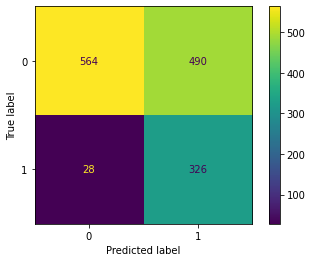

In [27]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc = metrics.roc_auc_score(y_test, preds)

plot_confusion_matrix(best_model, X_test, y_test)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

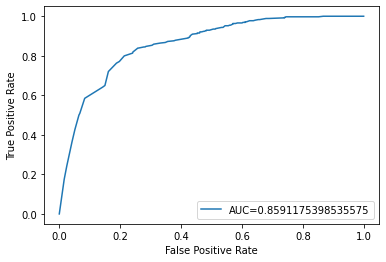

In [36]:
#define metrics
y_pred_proba = best_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_proba, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, y_pred_proba)

print(auc_score1)

0.8591175398535575


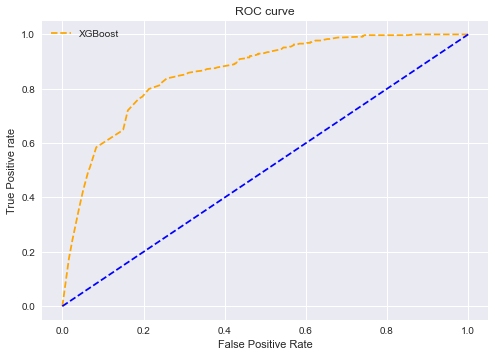

In [40]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='XGBoost')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [41]:
tpr1

array([0.        , 0.17514124, 0.24293785, 0.36440678, 0.42090395,
       0.42655367, 0.5       , 0.50847458, 0.58474576, 0.64124294,
       0.64971751, 0.72033898, 0.76271186, 0.77118644, 0.79943503,
       0.81355932, 0.81920904, 0.83898305, 0.83898305, 0.84463277,
       0.84463277, 0.84463277, 0.84745763, 0.85310734, 0.85875706,
       0.86440678, 0.86723164, 0.86723164, 0.87288136, 0.87288136,
       0.87570621, 0.87570621, 0.87570621, 0.87853107, 0.88983051,
       0.89265537, 0.89265537, 0.89830508, 0.90112994, 0.90960452,
       0.90960452, 0.91242938, 0.91242938, 0.91525424, 0.91525424,
       0.91525424, 0.91525424, 0.92090395, 0.92090395, 0.92090395,
       0.92372881, 0.92372881, 0.92372881, 0.92655367, 0.92655367,
       0.92937853, 0.92937853, 0.92937853, 0.92937853, 0.92937853,
       0.93502825, 0.93502825, 0.93785311, 0.93785311, 0.94350282,
       0.94350282, 0.94350282, 0.9519774 , 0.9519774 , 0.9519774 ,
       0.9519774 , 0.9519774 , 0.95480226, 0.95480226, 0.96045

## Implementation

In [34]:
best_model.save_model('../project/model/xgboost_model.pickle.dat')

In [44]:
load_model = xgb.XGBClassifier()
load_model.load_model('../project/model/xgboost_model.pickle.dat')

In [45]:
load_model.predict_proba(X_test)[::,1]

array([0.21883932, 0.32314122, 0.21535492, ..., 0.7356782 , 0.54051733,
       0.33824944], dtype=float32)